# Supervised Learning
## Project: Identifying Potential Donors

### Contents
1. Introduction
2. Data Import
3. Data Exploration
4. Preprocessing
5. Model Performance
6. Supervised Learning Models
7. Model Tuning (Grid Search)
8. Feature Importance

Appendix

___


___

## 1. Introduction
The following project implements several supervised learning algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census.

In this fictitious scenario the goal is to identify potential donors for the advancement of the beneficial use of artificial intelligence in Sub-Saharan Africa. 

The underlying scenario assumes that people who earn more than 50,000 USD per year are much more likely to donate for this cause. Therefore, we'd like to employ a model to find those individuals based on variables like educational level, age and others. 

After some preliminary data exploration I proceed to construct a model with the goal of accurately predicting whether an individual makes more than 50,000 USD or not.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/census+income) and was donated by Ron Kohavi and Barry Becker after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_ and can be found  [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf).

The data used in this notebook is slightly modified. E.g. removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

--- 
## 2. Data Import 
Loading the necessary Python libraries and the census data. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, 50,000 USD annually). All other columns are individual-specific features in the census database.

In [1]:
from time import time
start_notebook = time()

# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display 

# Import supplementary visualization code visuals.py
import visuals as vs

# plotting in jupyter notebook
%matplotlib inline

# Load census csv
data = pd.read_csv("census.csv")

---
## 3. Data Exploration
A first look at the data and some basic exploration, descriptive statistics.

In [2]:
# head of the data
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# Calculate descriptive stats
n_records = data.shape[0]
n_greater_50k = (data["income"] ==">50K").sum() 
n_at_most_50k = (data["income"] =="<=50K").sum()
greater_percent = (n_greater_50k / n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.4}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Note that we have variables which are nominally scaled, which we do not like for our algorithms. Hence, preprocessing is required.

First, dummy variables (binary varibales) will be added for each categorical variable (e.g. education level). This is also known under the slightly fancier name of **One-Hot-Encoding**.

Example: 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

As there is no natural order between all features, they will be treated equally. The way to implement this is to include a dummy variabe for each category indicating whether the individual "possesses" this characteristic or not.

For more information on the features I refer to the data set description [here](https://archive.ics.uci.edu/ml/datasets/census+income).

----
## 4. Preprocessing
In this section we will get into the weeds of processing our data in a way our algorithms can deal with them. Fortunately, there are no invalid or missing entries left that we must take on as this dataset has already been cleaned. 

For inspiration on how to deal with missings, invalid entries and other nasty variables I refer to the respective part in my **Customer Segmentation (Unsupervised Learning)** project.

However, there are some qualities about certain features that must be adjusted. This processing also helps us with the outcome and predictive power of most supervised learning algorithms. The respective steps in processing our data are:

- Splitting data into features and label (x,y)
- Transforming skewed continous features (log-transform)
- Normalizing numerical features to (0,1)
- Include dummy variables for categorical features (aka one-hot encoding)
- Shuffle and split the data 

### Transforming Skewed Continuous Features
We have two features which are are heavily skewed towards one value, namely: 

'`capital-gain'` and `'capital-loss'`

Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.

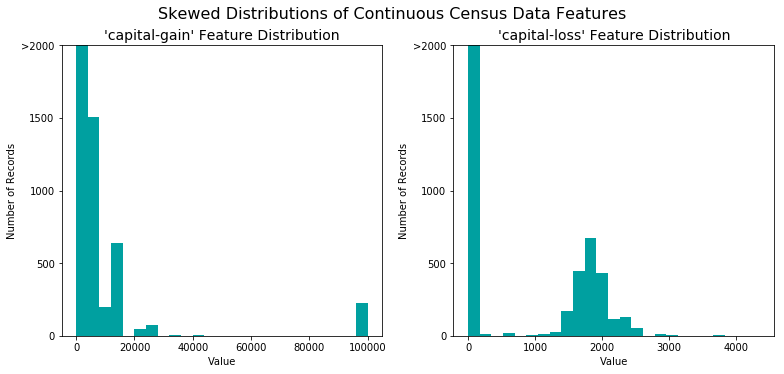

In [4]:
# Visualize skewed continuous features of original data
vs.distribution(data)

As the values vary by a lot, a data transformation seems to be appropriate here. We will use a simple logarithmic transformation to reduce the range of values. Other data transformations (e.g. Box-Cox transformation) may also be applied here. But we will keep it as simple as possible for now.

The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the logarithm successfully. 

Before the transformation we split the data into features (x) and target label (y) that will be fed to the algorithms later. 

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

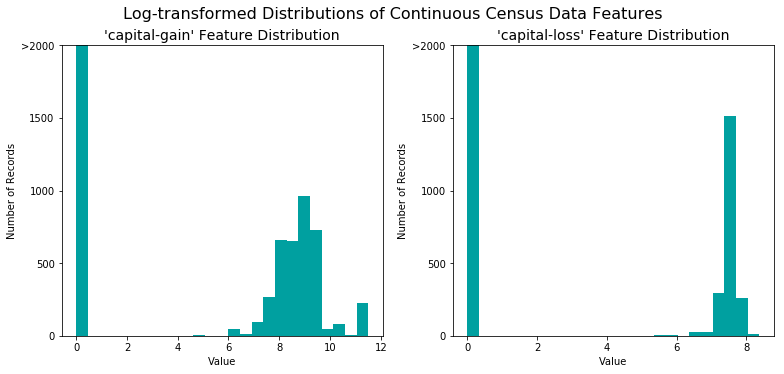

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

Note that the range now is considerably narrower as before...

### Normalizing Numerical Features 
Moreover, we have to apply a scaling to the numerical data features to ensure that each feature is treated equally when applying our algorithms. The shape of a feature's distribution remains the same. Also, once scaling is applied the data will no longer have the same original meaning. 

We can write our own function or simply use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to do this for us. The function scales the data to a range of (0,1) by default. 

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler and apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with applied scaling
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


Tadaa! Continous data is mapped to a range of zero to one.

### Implementation: Data Preprocessing
We have not dealt with our categorical variables yet which will be our next step. Hang on, we are getting closer... 

Most supervised algorithms expect input to be numeric and, thus, categorical features need to be converted (or vectorized) into a mathematically interpretable space. One way to do this is to use dummy variables (one-hot encoding) for each category. 

Additionally, we also need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as a binary variable of `0` and `1`, respectively. 

In [8]:
# dummies for the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({"<=50K": 0, ">50K":1})

# Print number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# See the first ten feature names after encoding
print(encoded[:10])

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc']


In [9]:
# Another look at the features...
features_final.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Shuffle and Split Data
So far: 
- All categorical variables have been converted into numerical features
- All numerical features have been normalized. 

Next step is to split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [10]:
# Import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## 5. Model Performance
In the following section we compare supervised learning algorithms with respect to their speed and performance (accuracy and f-beta score). In addition, a naive predictor is implemented, which will be used as baseline. 

### Metrics and the Naive Predictor
Now, a subjective assessment has to be made on wich metric is most suited  for our application. Simply taking the **accuracy** of our predictions may not best way to deal with this problem as we likely prefer one error over the other (eg. False Positives aka type I error over False Negatives aka type II errors). 

Choosing a metric needs careful reasoning of what situations we'd like to avoid and which type of mistake we are more willing to make. For illustration think of a cancer-detecting algorithm in image processing. Such an algorithm should try to minimize False Negatives (i.e. not detecting cancer given patient has cancer) at the expense of False Positives (detecting cancer given patient does not have cancer). The first case leads to patients falsely classified as healthy and sent home, whereas the latter may be followed up by additional tests to verify this first diagnosis.

More ressources for an overview of this problem:
- [Classification Accuracy is not enough](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)
- [Performance Metrics for Classification problems in ML](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b)

In our case we are interested in the model's ability to precisely predict those that make more than 50,000 USD and minimizing those wrongly identified as making more than 50,000 USD. The reasoning here is that contacting potential donors is expensive and we want to make sure that those individuals who are contacted actually fall in the right category. This can be restated as minimizing False Positives (type I error) at the expense of False Negatives (type II error). Hence, a different metric to simple accuracy may be appropriate.

In Machine Learning this trade-off is often described using the concepts of  **precision** and **recall**:
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

If we want to have a metric that tends toward precision (minimizing False Positives), we can use the **F-beta score** with  $\beta = 0.5$, as a metric that considers both precision and recall with tendency towards precision:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

$\beta = 0.5$ indicates that more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity). $\beta=1$ would lead to the harmonic mean of precision or recall and is known as $F_1$-Score.

#### The Naive Case
Looking at the distribution of classes (those who make at most 50,000 USD, and those who make more), it's clear most individuals do not make more than 50,000 USD. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than 50,000 USD"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than 50,000 USD, we would identify no one as donors. 

See Appendix for more information.

In [11]:
TP = np.sum(income) # Counting the ones as this is the naive case. 
FP = income.count() - TP # Specific to the naive case, same as (income == 0).sum()

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP+TN) / (TP+FP)
recall = TP / (TP+FN) # same as sensitivity and one as expected
precision = TP / (TP+FP) # same as accuracy as TN=0

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = ( (1+beta**2)*precision*recall ) / (beta**2 * precision + recall)

# Print the results 
print("Naive Predictor")
print("Accuracy score: {:.4f} \nF-Score: {:.4f}".format(accuracy, fscore))

Naive Predictor
Accuracy score: 0.2478 
F-Score: 0.2917


## 6.  Supervised Learning Models
We will implement the models using [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html). Note that the code can easily be modified to implement one of the following algorithms:

- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

Short, intuitive explanations of the chosen models have been added at the end of the Analysis in the appendix section.

### Training and Predicting
To evaluate the performance of each model, we create a training and predicting pipeline to quickly and effectively train models using different sizes of training data and perform predictions on the testing data.

In the code block below, we will implement the following:
- Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
- Fit the classifier to the sampled training data and record the training time.
- Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
- Record total prediction time.

In addition, 
- Calculate accuracy score for both the training subset and testing set.
- Calculate F(0.5)-score for the training subset and testing set.

In [12]:
# Import fbeta_score and accuracy_score as metrics
from sklearn.metrics import fbeta_score, accuracy_score

# Implement train-predict function
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Predictions on the test set(X_test),
    # then get predictions on the first 300 training samples
    start = time() # take the time again
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    # Calculate total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success?!?
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
     
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

C:\Users\TM\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


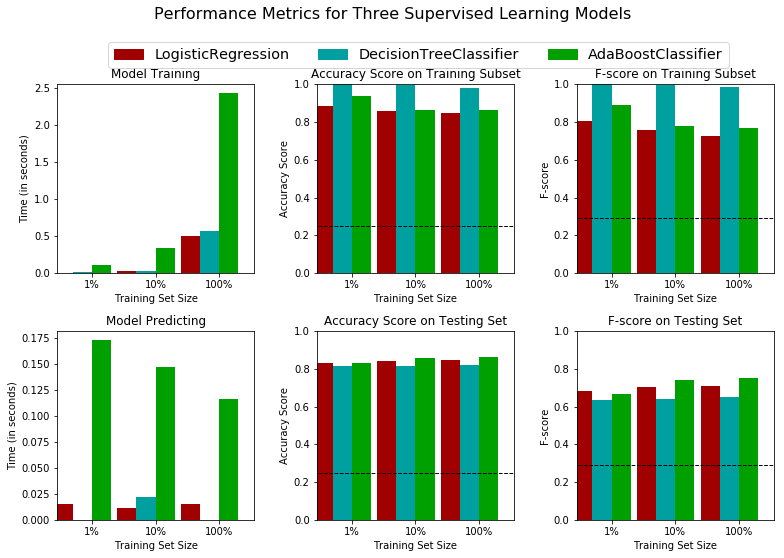

In [13]:
# Import supervised learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the three models
clf_A = LogisticRegression()
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# Unquote to change classifiers...:
# clf_A = SVC()
# clf_B = RandomForestClassifier(random_state=42)
# clf_C = BaggingClassifier(random_state=42)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(round(len(y_train)*0.1))
samples_1 = int(round(len(y_train)*0.01))

# Collect results on the classifiers
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run visualization
vs.evaluate(results, accuracy, fscore)

In [14]:
# Check individual stats for classifier C
results = train_predict(clf_C, samples, X_train, y_train, X_test, y_test)
for key, value in results.items():
    print(key, round(value, 4))

AdaBoostClassifier trained on 36177 samples.
train_time 2.2871
pred_time 0.1068
acc_train 0.8667
acc_test 0.8607
f_train 0.7703
f_test 0.7491


## Results

**Logistic Regression Classifier:**
- Logistic regression performs comparably well to the untuned classifiers on the training as well as the test data, even though it may appear rather simplistic compared to the other two classifiers.
- Metrics: The $F_{0.5}$-Score of `0.6832` on the testing data is comparable to the untuned adaboost classifier and comparable to the F-Score of the training data of `0.6985`. This indicates that this classifier does not overfit the data. It performs not as good on the training data as the adaboost algorithm but way better than the untuned version of decision trees as the latter appears to massively overfit ('memorize') the data. 
- Prediction/training time: It has a very low prediction and training time due to its simplicity.
- Suitability: The algorithm is well suited for this case as the outcome variable is binomially distributed (0/1). However, due to the skewed nature of the data we should adjust this model's threshold value as it implicitly assumes 1 for $p \geq 0.5$ which is bad practice in this case. The optimal threshold value could be obtained using the ROC-Curve. 

**Random Forest Classifier:**
- Random Forest classifier performs almost perfectly on the training data even if there are only few data being used. Moreover, the prediction and training time is modest. 
- However, the model does not perform that good on unseen data (testing set) and for small amount of data it even performs worse than logistic regression. 
- $F_{0.5}$-Score on the testing set for the full data is smaller than that of the adaboost classifier and almost identical to the Logistic regression classifier.

**AdaBoost Classifier:**
- Of the applied algorithms the adaboost implementation has the lowest F-Score on the training dataset which is the main measure to evaluate our algorithms in the framework of this problem. 
- Metrics: The $F_{0.5}$-Score of `0.7115` for the training data is between the extreme value of the decision tree and the moderate value of the logistic regression classifier. More importantly the $F_{0.5}$-Score for the test data is the highest with `0.7246` and will thus be considered as the "best" among these three models
- prediction/training time: However, the time to train and predict is significantly higher than using the other two models.
- Suitability: This implementation is well suited for our problem. Unlike the decision tree which tends to overfit the AdaBoost Classifier generalizes way better to out-of-sample data which we want in this setting. Moreover, its predictions are more accurate in terms of accuracy as well as the $F_{0.5}$-Score


--- 

## 7. Model Tuning (Grid Search)


#### AdaBoost
It seems as the AdaBoost algorithm performs better than the other two chosen models. In the following, we will try to squeeze out of this method and improve on our untuned version of this classifier. 

Before this, we will briefly look at what exactly AdaBoost is?

- The AdaBoost algorithm uses decision trees as default "weak learner" and weighs these decision trees in a particular way
- It is a weighting algorithm that can be applied to any classification algorithm but is commonly used with decision trees leading in general to a very good performance.  
- Also, it is only one of different boosting algorithms (you probably heard of XGBoost) which have the goal to combine many "weak learners" (simple classifiers) to create a very accurate classifier. 
- The algorithm combines these weaker predictions from low-level decision trees by sequentially adjusting the weight of the individual contributions to a weighted sum. The result is a classifier that consists of weighted decision trees. 
- Weights are adjusted (or "ADApting") sequentially after each individual classifier is trained and misclassified points are identified. The weight of those misclassified data is then increased. More accurate classifiers are given more weight and vice versa.

To summarize, Adaboost uses the individual weak learners (decision trees in this case), combines them according to the previously determined weights and constructs a strong learner, which is used for prediction. The prediction is a type of "voting" scheme to determine the most likely outcome in each "area" of the prediction space.

#### Model Tuning (Grid Search)
Next, we will tune the AdaBoost model using grid search. We will take the following steps:

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).

- Initialize the classifier and store it in `clf`.
- Creating a dictionary of parameters to tune
 - `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and storing it in `grid_obj`.
- Fit grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

Note that the implementation of grid search may take some time depending on your setup.

In [15]:
# Import necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

# Initialize classifier
clf = AdaBoostClassifier(random_state=42)

# Parameters to tune
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"n_estimators": [100, 200, 300, 400, 600]}

# Fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Grid search on classifier. 'scorer' as scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit grid search object
grid_fit = grid_obj.fit(X_train, y_train)

# Get best estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [16]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nChange in Accuracy/F-Score due to hyperparameter tuning \n------")
acc_diff = accuracy_score(y_test, best_predictions) - accuracy_score(y_test, predictions)
f_diff = fbeta_score(y_test, best_predictions, beta = 0.5) - fbeta_score(y_test, predictions, beta = 0.5)
print("Change of Accuracy-Score: {:.4f}".format(acc_diff))
print("Change of F-Score (beta=0.5): {:.4f}".format(f_diff))

Unoptimized model
------
Accuracy score on testing data: 0.8607
F-score on testing data: 0.7491

Optimized Model
------
Final accuracy score on the testing data: 0.8698
Final F-score on the testing data: 0.7663

Change in Accuracy/F-Score due to hyperparameter tuning 
------
Change of Accuracy-Score: 0.0091
Change of F-Score (beta=0.5): 0.0172


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8607            | 0.8698          |
| F-score        | 0.7491            | 0.7663          |


After optimization of the model, accuracy as well as the $F_{0.5}$-Score have increased!

However, the increase seems to be rather small in comparison to the unoptimized model. Note however - as mentioned before - the AdaBoost algorithm is an algorithm which in general provides good results even without excessive hyperparameter tuning.

Moreover, the unoptimized and optimized model of the AdaBoost algorithm performs significantly better than most other supervised algorithms (even for those whose results were not shown) and provides good results for classification in our case.


----
## 8. Feature Importance

An important task when performing supervised learning on a dataset like the census data we studied is determining which features provide the most predictive power. 

By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than 50,000 USD.

We choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute. This is a function that ranks the importance of features according to the classifier. We will use this to determine the top 5 most important features for the census dataset.

### Extracting Feature Importance
In the code cell below, we will implement the following:
 - Import a supervised learning model
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

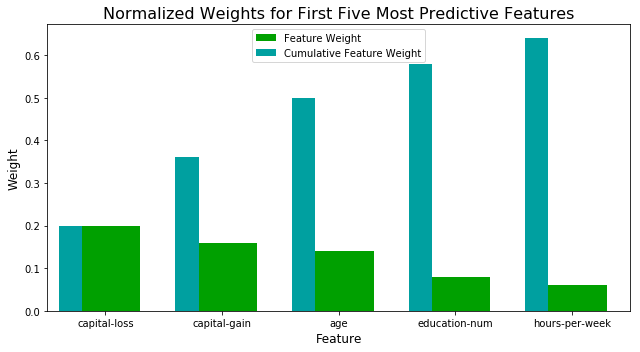

In [17]:
# Import supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## Results: Feature Importance
The features with the most predictive power seem to be:
- `capital-loss`
- `capital-gain`
- `age`
- `education-num`: Education in years
- `hours-per-week`: Working hours per week

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data?

From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. 

This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn. The code cell below will use the same optimized model we found earlier, and train it on the same training set with only the top five important features. 

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space using only top5 features
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced feature space\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8698
F-score on testing data: 0.7663

Final Model trained on reduced feature space
------
Accuracy on testing data: 0.8409
F-score on testing data: 0.7180


### Effects of Feature Selection
Even after reducing the feature space considerably we still get results that are surprisingly good. With only five features, instead of 103 before, we can make predictions almost as good as before.

However: Yes, the reduced model performs worse than the full model but it should be repeated that the new model has only 5 features compared to over 100 in the previous case. 

In case training time or data availability is a factor, the reduced form can definitely help here. In addition, reducing the complexity of the model without harming the performance too much can be valuable in communicating results and explaining the model to other people.

---
## Appendix:
---  

#### Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall (sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

Some additional notes about the implemented models:

### Model: Logistic Regression 
- Application: Logistic Regression is a form of binary regression which uses the logistic function to model the dependent variable. It is a widely used tool in statistics as a simple and intuitive method to model output probability. It should be noted that logistic regression outputs a probability of one result vs. the other. Hence, the threshold may not necessarily be 0.5 in the event of skewed data. It can be used to predict risks of failure in technical applications, credit card default risk, risk of a disease based on covariates and many more [Link](https://en.wikipedia.org/wiki/Logistic_regression#Applications). 
- Strenghts: Simplicity and interpretability as well as it requires only limited computing power. It is fast in training and prediction and gives good results even with limited amount of features.
- Weaknesses: Assuming a 50% threshold, which is often implicitly done, may not be a good idea for skewed data [Link](https://www.cambridge.org/core/journals/political-analysis/article/logistic-regression-in-rare-events-data/1E09F0F36F89DF12A823130FDF0DA462). Moreover, there are more precise techniques for modeling complex data (e.g. to capture nonlinear relationships). 
- Model candidate: Good candidate as the task is a binary classification problem

### Model: Random Forest Classifier
- Application: Used for spam identification, banking (e.g. fraud detection), Finance  [determine stock's behaviour](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544), Medicine (Identify diseases), Commerciallly (predict whether a customer will buy the product or not, Bioinformatics [Time Series Forecasting](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276)
- Strenghts: Main problem that the random forest classifier trying to solve is the overfitting of decision trees (low bias, high variance model); Decision trees can grow very deep and seem to "memorize" the data they were trained on very well. Whereas this almost entirely eliminates the in-sample error this procedure is not generalizable and thus not a good tool for prediction. Random Forest corrects for this; Easy to measure the relative importancae of each feature based on reduced impurity across alle trees (which can be easily calculated using sklearn) and makes this algorithm a little bit more transparent; Can be used for regression and classification tasks;
- Weaknesses: In case there are only limited relevant variables random forests may likely perform poorly if the number of random features to be chosen is small. This is due to the fact that the chance to randomly select the important variables is small; Problem is often overfitting (if there are not enough trees in the forest); Large number of trees can make the algorithm to slow down significantly (poor run-time performance);  
- Model candidate: Easy to apply and performs well with categorical variables. Moreover, dataset is not too big which should keep the computing time reasonable.

### Model: AdaBoost Classifier
- Application: The algorithm can be used for [object detection](http://uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) or [face recognition](https://www.computer.org/csdl/proceedings/fg/2004/2122/00/21220079.pdf). 
- Strengths: Powerful algorithm for classification and does not require a lot of hyperparameter tuning to deliver good results. 
- Weaknesses: Algorithm may be slow to train in case of big data. Mreover, the 
 - Algorithm can be sensitive to outliers.

In [29]:
# The following command translates the notebook to html file...
# !!jupyter nbconvert *.ipynb
end_notebook = time()

# running time notebook on my laptop  
print("time to run the entire notebook: ")
Time_notebook = end_notebook - start_notebook
print("Notebook finished in: ", time_notebook)

time to run the entire notebook: 
Notebook finished in:  271.7637605667114
